In [2]:
""" 
Helper methods for loading and parsing KITTI data.

"""

import numpy as np

class Object3d(object):
    # 0 - easy, 1 - medium, 2 - hard
    HEIGHT = (40, 25, 25)
    OCCLUSION = (0, 1, 2)
    TRUNCATION = (0.15, 0.3, 0.5)

    ''' 3d object label '''
    def __init__(self, label_file_line):
        data = label_file_line.split(' ')
        data[1:] = [float(x) for x in data[1:]]

        # extract label, truncation, occlusion
        self.type = data[0] # 'Car', 'Pedestrian', ...
        self.truncation = data[1] # truncated pixel ratio [0..1]
        self.occlusion = int(data[2]) # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3] # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4] # left
        self.ymin = data[5] # top
        self.xmax = data[6] # right
        self.ymax = data[7] # bottom
        self.box2d = np.array([self.xmin,self.ymin,self.xmax,self.ymax])

        # extract 3d bounding box information
        self.h = data[8] # box height
        self.w = data[9] # box width
        self.l = data[10] # box length (in meters)
        self.t = (data[11],data[12],data[13]) # location (x,y,z) in camera coord.
        self.ry = data[14] # yaw angle (around Y-axis in camera coordinates) [-pi..pi]
        self.difficulty = self._get_difficulty()

    def _get_difficulty(self):
        difficulty = 0
        for i in range(3):
            if not ((self.occlusion <= self.OCCLUSION[i]) and
                (self.truncation <= self.TRUNCATION[i]) and
                (self.ymax - self.ymin) >= self.HEIGHT[i]):
                difficulty += 1
        difficulty = min(2, difficulty)
        return difficulty



class Calibration(object):
    ''' Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf

        TODO(rqi): do matrix multiplication only once for each projection.
    '''
    def __init__(self, calib_filepath):
        
        calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3,4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs['Tr_velo_to_cam']
        self.V2C = np.reshape(self.V2C, [3,4])
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0,[3,3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0,2]
        self.c_v = self.P[1,2]
        self.f_u = self.P[0,0]
        self.f_v = self.P[1,1]
        self.b_x = self.P[0,3]/(-self.f_u) # relative
        self.b_y = self.P[1,3]/(-self.f_v)

    def read_calib_file(self, filepath):
        ''' Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        '''
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line)==0: continue
                key, value = line.split(':', 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data


"""
Rotation about the y-axis. 
"""
def roty(t):
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c,  0,  s],
                     [0,  1,  0],
                     [-s, 0,  c]])



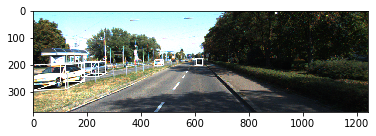

In [25]:
import numpy as np
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
import os
import pickle
#from kitti_object import Object3d, Calibration

"""
Display the image with boxes
"""
def show_image_with_boxes(img, objects, calibFile, is_kitti_format, show3d=True):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Show image with 2D bounding boxes
    img1 = np.copy(img) 
    img2 = np.copy(img) 
    # Fetch the calibration file
    calib = Calibration(calibFile)
    if is_kitti_format:
        # Fetch the coordinate lines
        with open(objects, 'r') as objFile:
            for line in objFile: 
                obj = Object3d(line)
                cv2.rectangle(img1, (int(obj.xmin),int(obj.ymin)),
                    (int(obj.xmax),int(obj.ymax)), (0,255,0), 2)
                box3d_pts_2d, box3d_pts_3d = compute_box_3d(obj, calib.P, True)
                img2 = draw_projected_box3d(img2, box3d_pts_2d)
    else:
        for obj in objects:
            box3d_pts_2d, box3d_pts_3d = compute_box_3d(obj, calib.P, False)
            img2 = draw_projected_box3d(img2, box3d_pts_2d)
    # Display the image with 3d
    if show3d:
        Image.fromarray(img2).show()
        imshow(np.asarray(img2))
        
"""
Draw 3d bounding box in image
"""       
def draw_projected_box3d(image, qs, color=(255,255,255), thickness=2):
    if qs is not None:
        qs = qs.astype(np.int32)
        for k in range(0,4):
           # Ref: http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
           i,j=k,(k+1)%4
           # use LINE_AA for opencv3
           cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness, cv2.LINE_AA)

           i,j=k+4,(k+1)%4 + 4
           cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness, cv2.LINE_AA)

           i,j=k,k+4
           cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness, cv2.LINE_AA)
    return image

"""
 Rotation about the y-axis. 
"""
def roty(t):
    
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c,  0,  s],
                     [0,  1,  0],
                     [-s, 0,  c]])

    
"""
Project 3d points to image plane.
    Usage: pts_2d = projectToImage(pts_3d, P)
      input: pts_3d: nx3 matrix
             P:      3x4 projection matrix
      output: pts_2d: nx2 matrix
      P(3x4) dot pts_3d_extended(4xn) = projected_pts_2d(3xn)
      => normalize projected_pts_2d(2xn)
      <=> pts_3d_extended(nx4) dot P'(4x3) = projected_pts_2d(nx3)
          => normalize projected_pts_2d(nx2)
"""
def project_to_image(pts_3d, P):
    
    n = pts_3d.shape[0]
    pts_3d_extend = np.hstack((pts_3d, np.ones((n,1))))
    # print(('pts_3d_extend shape: ', pts_3d_extend.shape))
    pts_2d = np.dot(pts_3d_extend, np.transpose(P)) # nx3
    pts_2d[:,0] /= pts_2d[:,2]
    pts_2d[:,1] /= pts_2d[:,2]
    return pts_2d[:,0:2]


"""
Takes an object and a projection matrix (P) and projects the 3d
        bounding box into the image plane.
        Returns:
            corners_2d: (8,2) array in left image coord.
            corners_3d: (8,3) array in in rect camera coord.
"""
def compute_box_3d(obj, P, is_kitti_format):
    if is_kitti_format:
        # compute rotational matrix around yaw axis
        R = roty(obj.ry)

        # 3d bounding box dimensions
        l = obj.l;
        w = obj.w;
        h = obj.h;
    else:
        R = roty(obj['pred_r_y'])
        
        l = obj['pred_l']
        w = obj['pred_w']
        h = obj['pred_h']

    # 3d bounding box corners
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2];
    y_corners = [0,0,0,0,-h,-h,-h,-h];
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2];

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    #print corners_3d.shape
    if is_kitti_format:
        corners_3d[0,:] = corners_3d[0,:] + obj.t[0];
        corners_3d[1,:] = corners_3d[1,:] + obj.t[1];
        corners_3d[2,:] = corners_3d[2,:] + obj.t[2];
    else:
        corners_3d[0,:] = corners_3d[0,:] + obj['pred_center_BboxNet'][0];
        corners_3d[1,:] = corners_3d[1,:] + obj['pred_center_BboxNet'][1];
        corners_3d[2,:] = corners_3d[2,:] + obj['pred_center_BboxNet'][2];
    #print 'cornsers_3d: ', corners_3d
    # only draw 3d bounding box for objs in front of the camera
    if np.any(corners_3d[2,:]<0.1):
        corners_2d = None
        return corners_2d, np.transpose(corners_3d)

    # project the 3d bounding box into the image plane
    corners_2d = project_to_image(np.transpose(corners_3d), P);
    #print 'corners_2d: ', corners_2d
    return corners_2d, np.transpose(corners_3d)

# Invoke the method with correct directories.
dirname = os.path.dirname("__file__")
#show_image_with_boxes(os.path.join(dirname, r"../sampleDataForVis/006005.png"), 
 #                     os.path.join(dirname,r"../sampleDataForVis/006005.txt"),
  #                    os.path.join(dirname,r"../sampleDataForVis/calib_006005.txt"), True)

# Run the visualization of results obtained as part of training an ImageOnly network 
with open(os.path.join(dirname, r"../sampleDataForVis/eval_dict_test.pkl"), "rb") as eval_file:
    eval_dict = pickle.load(eval_file)
    for img_id in eval_dict:
        if img_id == "001553":
            bbox_dicts = eval_dict[img_id]
            #show_image_with_boxes(os.path.join(dirname, r"../sampleDataForVis/001553.png"), 
                     # bbox_dicts,
                      #os.path.join(dirname,r"../sampleDataForVis/calib_001553.txt"), False)
            
        if img_id == "006480":
            bbox_dicts = eval_dict[img_id]
            #show_image_with_boxes(os.path.join(dirname, r"../sampleDataForVis/006480.png"), 
                      #bbox_dicts,
                      #os.path.join(dirname,r"../sampleDataForVis/calib_006480.txt"), False)


bbox_dicts = os.path.join(dirname, r"../sampleDataForVis/000106.txt")
show_image_with_boxes(os.path.join(dirname, r"../sampleDataForVis/000106.png"), 
          bbox_dicts,
          os.path.join(dirname,r"../sampleDataForVis/calib_000106.txt"), True)

            
            